Loaded image: d:\research\data\images\rgb\000000.png
Image size: (640, 480)


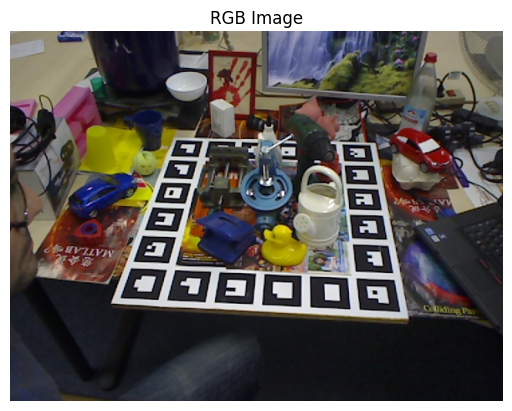

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt


# Define the directory where the RGB images are stored.
rgb_dir = r"d:\research\data\images\rgb"

# List and sort all image files (adjust extensions as needed).
image_files = sorted([f for f in os.listdir(rgb_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

if image_files:
    # Load the first image.
    first_image_path = os.path.join(rgb_dir, image_files[0])
    rgb_image = Image.open(first_image_path).convert("RGB")
    
    print("Loaded image:", first_image_path)
    print("Image size:", rgb_image.size)
    
    # Display the image.
    plt.imshow(rgb_image)
    plt.axis("off")
    plt.title("RGB Image")
    plt.show()
else:
    print("No RGB images found in", rgb_dir)

In [2]:
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from models.shared_encoder import SharedEncoder

# Define a transform to resize and convert the image to tensor.
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
# Apply the transform.
img_tensor = transform(rgb_image).unsqueeze(0) 

# Initialize the shared encoder with pretrained weights.
encoder = SharedEncoder(pretrained=True)
encoder.eval()

# Forward pass the image through the encoder.
with torch.no_grad():
    features = encoder(img_tensor)

print("Feature shape from encoder:", features.shape)

d:\research\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature shape from encoder: torch.Size([1, 2048, 8, 8])


Feature shape from encoder: torch.Size([1, 2048, 8, 8])
Vector field shape from decoder: torch.Size([1, 2, 16, 16])


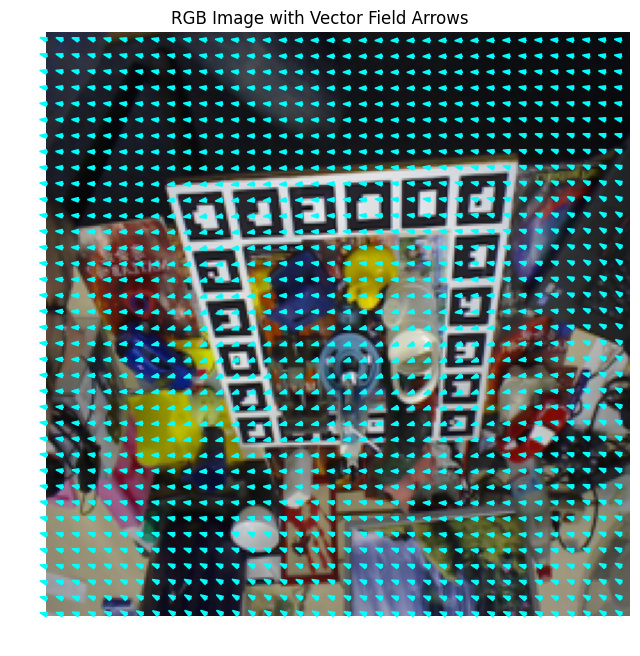

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from models.decoder import PoseCNNVectorFieldDecoder
from models.shared_encoder import SharedEncoder

# Set target image size.
target_size = (256, 256)

# ----- Load the RGB Image -----
rgb_dir = r"d:\research\data\images\rgb"
image_files = sorted([f for f in os.listdir(rgb_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
if not image_files:
    raise ValueError("No RGB images found in " + rgb_dir)
rgb_path = os.path.join(rgb_dir, image_files[0])
rgb_image = Image.open(rgb_path).convert("RGB")

# Define a transform to resize and convert the image to tensor.
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image).unsqueeze(0)  # [1, 3, 256, 256]

# ----- Get Encoder Features -----
encoder = SharedEncoder(pretrained=True)
encoder.eval()
with torch.no_grad():
    features = encoder(img_tensor)
print("Feature shape from encoder:", features.shape)
C = features.size(1)

# ----- Process Encoder Features and Get Vector Field -----
decoder = PoseCNNVectorFieldDecoder(in_channels=C, out_channels=2)
decoder.eval()
with torch.no_grad():
    vector_field = decoder(features)
print("Vector field shape from decoder:", vector_field.shape)

# ----- Resize Vector Field to Match RGB Image Dimensions -----
vector_field_upsampled = torch.nn.functional.interpolate(vector_field,
                                                         size=target_size,
                                                         mode='bilinear',
                                                         align_corners=True)
B_vf, _, H_vf, W_vf = vector_field_upsampled.shape

# Convert the vector field to NumPy.
vector_field_np = vector_field_upsampled[0].cpu().numpy()  # [2, H_vf, W_vf]
U = vector_field_np[0]
V = vector_field_np[1]

# ----- Visualize: Overlay Vector Field on the RGB Image using Arrows -----
# Convert RGB tensor back to numpy (H x W x C).
rgb_np = np.transpose(img_tensor[0].cpu().numpy(), (1, 2, 0))

plt.figure(figsize=(8, 8))
plt.imshow(rgb_np)
plt.title("RGB Image with Vector Field Arrows")
plt.axis('off')

# Sample a coarser grid to plot arrows.
step = 7  # adjust as needed to prevent overcrowding
for i in range(0, H_vf, step):
    for j in range(0, W_vf, step):
        # Get the vector components from U,V at this grid point.
        dx = U[i, j]
        dy = V[i, j]
        # Draw arrow at position (j, i). plt.arrow expects (x, y) coordinates.
        plt.arrow(j, i, dx * 5, dy * 5, color='cyan', head_width=2, head_length=3)

plt.gca().invert_yaxis()  # optional: match image coordinate system
plt.show()